In [1]:
%load_ext autoreload
%autoreload 2

import sys, os, pickle, time, warnings
import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py

# Plotting modules
import matplotlib, corner
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
# Plotting modules
font = {'family' : 'serif', 'weight' : 'normal',
        'size'   : 16}
legend = {'fontsize': 16}
matplotlib.rc('font', **font)
matplotlib.rc('legend', **legend)
plt.rc('text', usetex=True)
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)

cm_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

corner_kwargs = {'max_n_ticks':3, 'title_kwargs':{"fontsize": 16}, 'label_kwargs':{'fontsize':16}}

# Load in data
Data generated in population.ipynb

In [3]:
size = 10000

In [4]:
sample = {}; true_pars={}; latent_pars={}
filename = '/data/asfe2/Projects/mwtrace_data/toymodel/sample.h'
with h5py.File(filename, 'r') as hf:
    subsample  = np.sort(np.random.choice(np.arange(len(hf['sample']['b'][...])), size=size, replace=False))
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subsample]
    for key in hf['true_pars'].keys():
        true_pars[key]=hf['true_pars'][key][...]
    for key in hf['latent_pars'].keys():
        latent_pars[key]=hf['latent_pars'][key][...]

In [5]:
true_pars['N'] = size

# Fit model

In [6]:
sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations

Model has two fiducial parameters:
    
$M_\mathrm{max}$ - The absolute magnitude cut-off.

$b_\mathrm{min}$ - The minimum latitude of stars in the sample.

In [7]:
fid_pars = {'Mbol_max_true':latent_pars['Mbol_max'],  'lat_min':true_pars['lat_min']}

Model has three free parameters:

$\log(\mathcal{N})$ - Expected number of stars in the model.

$\log(1/h_z)$ - Exponential scale height of the disk.

$\alpha$ - Power law of absolute magnitude distribution.

In [8]:
labels = np.array( [r'$\log(\mathcal{N})$',  r'$\log(1/h_z)$', r'$\alpha$'])
functions = [lambda x:np.exp(x), lambda x:1/np.exp(x), None]

true_params = np.array([np.log(true_pars['N']), np.log(1/true_pars['hz']), 
                        2*(true_pars['ep']-1)/true_pars['a']])

true_params

array([9.21034037, 0.69314718, 0.5       ])

### Run MCMC sampler

Observables: $\varpi, b, G$

Initialising parameters from uninformed start - random draw from uniform/logit-uniform distribution

In [9]:
bounds = np.array([[-np.inf,        -np.inf,          0.],
                   [ np.inf,         np.inf,          3.]])

p0 = np.array( [transformations.logit(np.random.rand()),
                transformations.logit(np.random.rand()),
                np.random.rand()*3] )
#p0 =     np.array( [3*np.log(10),                  2.,             0.1])
p0

array([2.33028728, 5.50876143, 0.16218266])

In [10]:
p0 = true_params.copy()

In [11]:
sample_2d = np.vstack((sample['parallax'], sample['b'],  sample['m']))

poisson_kwargs = {'sample':sample_2d, 'param_bounds':bounds, 
                  'logmodel':dcp.logmodel, 'model_integrate':dcp.integral_model, 
                  'bins':([0,np.inf],[-np.inf,np.inf]), 'fid_pars':fid_pars}

sampler_noerr = samplers.run_mcmc(p0, poisson_kwargs=poisson_kwargs, nstep=1000)

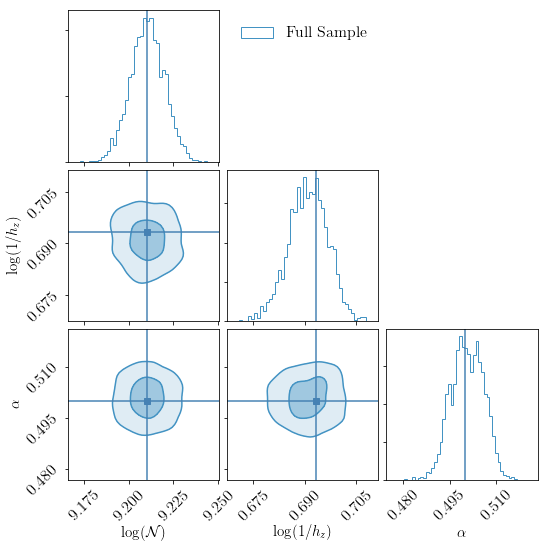

In [85]:
index = ['Full Sample']
plotting.layered_corners([sampler_noerr], labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8)])

MCMC chains have converged extremely well on the true parameters of the model

# Magnitude selection limited sample

Apply selection function to sample: $G < G_\mathrm{cut}$

In [13]:
Gcut = 16
print('Surviving sample: %d/%d'%(np.sum(sample['m']<Gcut), len(sample['m'])))

sample_2d = np.vstack((sample['parallax'], sample['b'],  sample['m']))[:,sample['m']<Gcut]

Surviving sample: 3602/10000


### If we don't account for magnitude cut:

In [14]:
poisson_kwargs = {'sample':sample_2d, 'param_bounds':bounds, 
                  'logmodel':dcp.logmodel, 'model_integrate':dcp.integral_model, 
                  'bins':([0,np.inf],[-np.inf,np.inf]), 'fid_pars':fid_pars}

sampler_Gcut = samplers.run_mcmc(p0, poisson_kwargs=poisson_kwargs, nstep=1000)

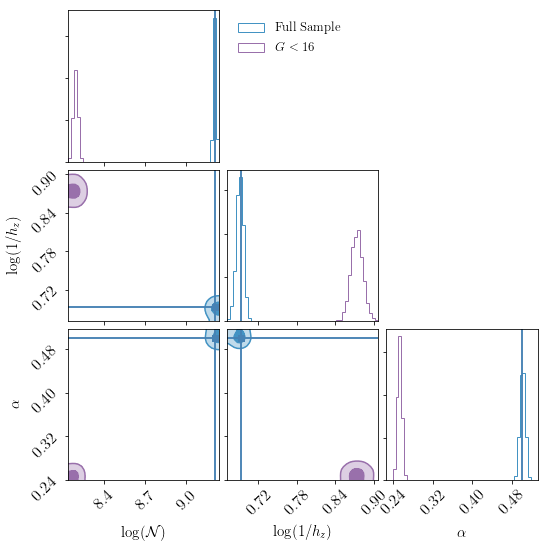

In [15]:
index = ['Full Sample', r'$G<%d$' % Gcut]
plotting.layered_corners([sampler_noerr, sampler_Gcut], 
                         labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8), cm.PRGn(0.2)])

### If we do account for magnitude cut by only integrating for G<16:

<font color='red'>For some reason when doing this, if the parameters aren't well initialised, the likelihood function returns nan values. - Need to debug this</font>

In [16]:
fid_pars['m_sf'] = Gcut
poisson_kwargs = {'sample':sample_2d, 'param_bounds':bounds, 
                  'logmodel':dcp.logmodel, 'model_integrate':dcp.integral_model_SF, 
                  'bins':([0,np.inf],[-np.inf,np.inf]), 'fid_pars':fid_pars}

sampler_Gcut = samplers.run_mcmc(p0, poisson_kwargs=poisson_kwargs, nstep=1000)

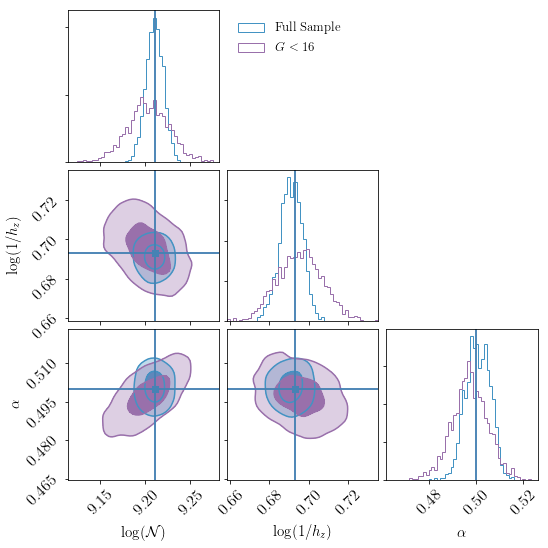

In [17]:
index = ['Full Sample', r'$G<%d$' % Gcut]
plotting.layered_corners([sampler_noerr, sampler_Gcut], 
                         labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8), cm.PRGn(0.2)])

# Parallax error
Now we use the observed parallax which is sampled from a Gaussian error for each source.

To do this with the standard Poisson likelihood, we need to only include sources with $\varpi>0$

In [29]:
sample_2d = np.vstack((sample['parallax_obs'], sample['b'],  sample['m']))[:,sample['parallax_obs']>0]

In [30]:
poisson_kwargs = {'sample':sample_2d, 'param_bounds':bounds, 
                  'logmodel':dcp.logmodel, 'model_integrate':dcp.integral_model, 
                  'bins':([0,np.inf],[-np.inf,np.inf]), 'fid_pars':fid_pars}

sampler_perr0 = samplers.run_mcmc(p0, poisson_kwargs=poisson_kwargs, nstep=1000)

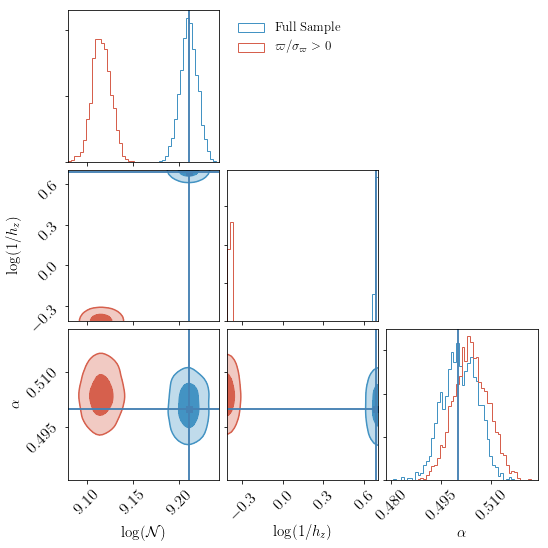

In [20]:
index = ['Full Sample', r'$\varpi/\sigma_\varpi>0$']
plotting.layered_corners([sampler_noerr, sampler_perr], 
                         labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2)])

We can also do this with only high SNR sources, e.g. $\varpi/\sigma_\varpi > 4$.

At this point, the selection effects of the SNR cut also become significant and ruin the inference.

In [21]:
sample_2d = np.vstack((sample['parallax_obs'], sample['b'],  
                       sample['m']))[:,sample['parallax_obs']/sample['parallax_error']>4]

print('Surviving sample: %d/%d'%(np.sum(sample['parallax_obs']/sample['parallax_error']>4), len(sample['m'])))

Surviving sample: 3481/10000


In [22]:
poisson_kwargs = {'sample':sample_2d, 'param_bounds':bounds, 
                  'logmodel':dcp.logmodel, 'model_integrate':dcp.integral_model, 
                  'bins':([0,np.inf],[-np.inf,np.inf]), 'fid_pars':fid_pars}

sampler_perr = samplers.run_mcmc(p0, poisson_kwargs=poisson_kwargs, nstep=1000)

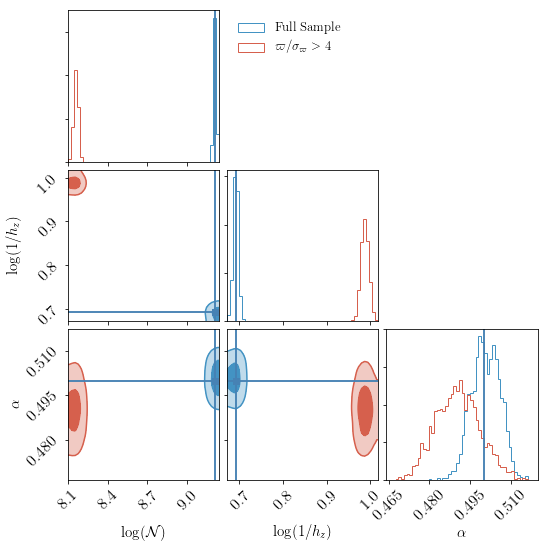

In [23]:
index = ['Full Sample', r'$\varpi/\sigma_\varpi>4$']
plotting.layered_corners([sampler_noerr, sampler_perr], 
                         labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2)])

But when we use the full sample and integrate over the parallax error we get more reasnoable results.

The integration needs to happen for every source at every iteration. As such it is extremely computationally expensive for large samples so we here only apply to a small subsample.

In [24]:
sample_2d = np.vstack((sample['parallax_obs'], sample['b'], sample['m'], sample['parallax_error']))

In [25]:
poisson_kwargs = {'sample':sample_2d, 'param_bounds':bounds, 
                  'logmodel':dcp.logmodel_perr_ridder, 'model_integrate':dcp.integral_model, 
                  'bins':([0,np.inf],[-np.inf,np.inf]), 'fid_pars':fid_pars}

sampler_perr_ridder = samplers.run_mcmc(p0, poisson_kwargs=poisson_kwargs, nstep=1000)

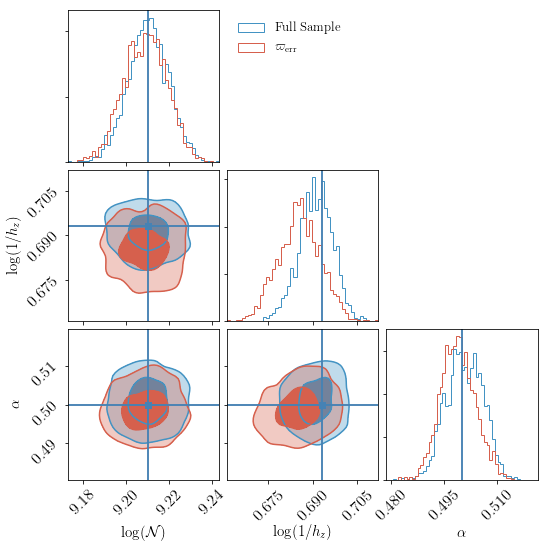

In [26]:
index = ['Full Sample', r'$\varpi_\mathrm{err}$']
functions = [lambda x:np.exp(x), lambda x:1/np.exp(x), None]
plotting.layered_corners([sampler_noerr, sampler_perr_ridder], 
                         labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2)])

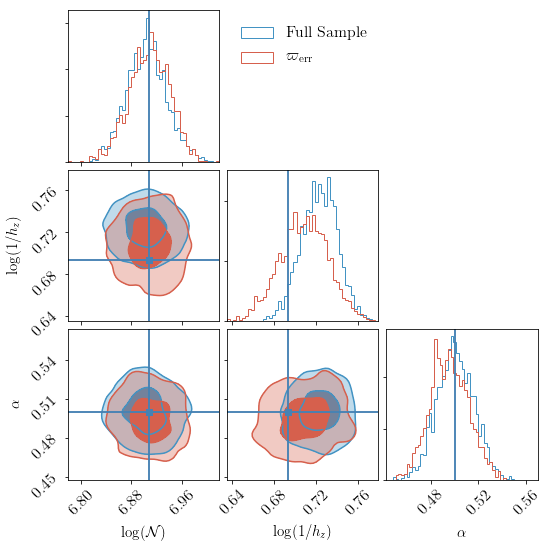

In [205]:
index = ['Full Sample', r'$\varpi_\mathrm{err}$']
functions = [lambda x:np.exp(x), lambda x:1/np.exp(x), None]
plotting.layered_corners([sampler_noerr, sampler_perr_ridder], 
                         labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2)])

# Comparison figure

In [82]:
plt.rc('legend',fontsize=16)

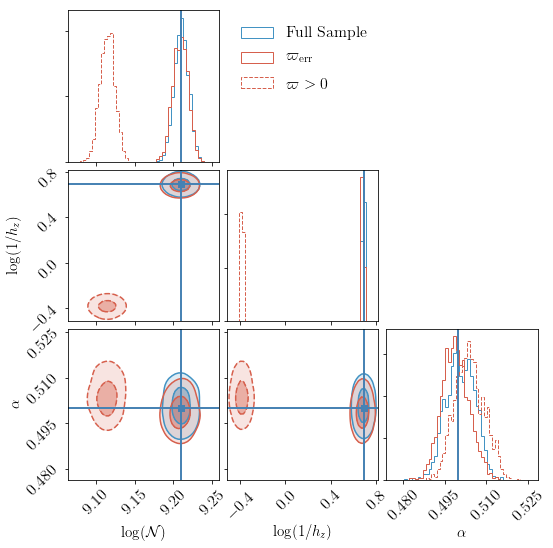

In [83]:
index = ['Full Sample', r'$\varpi_\mathrm{err}$', r'$\varpi > 0$']
functions = [lambda x:np.exp(x), lambda x:1/np.exp(x), None]
plotting.layered_corners([sampler_noerr, sampler_perr_ridder, sampler_perr0], 
                         labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2), cm.RdBu(0.2)],
                         linestyles=['-','-','--'], pad=0.1)